# Подготовка данных и окружения

Данные должны быть распакованы и находиться в текущей рабочей директории в следующем формате:
```
./
├── train/
│   ├── img/
│   │   ├── 1.png
│   │   └── ...
│   └── json/
│       ├── 1.json
│       └── ...
├── test/
│   ├── 10.jpg
│   └── ...
└── original.tiff
```
Также в текущей рабочей директории должны находиться все файлы из репозитория на Github, в особенности requirements.txt и директория с вспомогательными модулями/классами/функциями src
```
./
├── src/
│   ├── data.py
│   ├── inference.py
│   ├── train.py
│   └── utils.py
└── requirements.txt
```

Установим необходимые версии пакетов

In [13]:
!pip install -r ./requirements.txt -qqq

     |████████████████████████████████| 512 kB 16.7 MB/s 
     |████████████████████████████████| 113 kB 71.7 MB/s 
     |████████████████████████████████| 48.3 MB 136 kB/s 


Загрузим необходимые пакеты и модули

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import gc
import dill
import timm
import warnings
from pathlib import Path

Загрузим вспомогательные функции и классы из локальной директории

In [39]:
from src.data import ImageDataset, create_and_save_backgrounds, read_json_from_dir, get_transforms
from src.utils import get_file_paths
from src.train import criterion, train
from src.inference import predict_and_save

Будем производить обучение и предсказание на GPU

In [3]:
device = torch.device('cuda')

Сохраним расположение текущей рабочей директории

In [4]:
CWD = f'/content/'

# Загрузка и обработка данных

Загрузим данные из директории с json файлами и преобразуем их в датафрейм pandas

In [26]:
data_df = read_json_from_dir(json_dir = f'{CWD}train/json/',
                             image_dir = f'{CWD}train/img/')
data_df.head()

,path,left_top_x,left_top_y,right_top_x,right_top_y,left_bottom_x,left_bottom_y,right_bottom_x,right_bottom_y,angle
0,/content/train/img/998.png,1778.0,6876.0,2366.0,6037.0,2617.0,7464.0,3205.0,6625.0,305.0
1,/content/train/img/997.png,3671.0,3456.0,4620.0,3072.0,4055.0,4405.0,5004.0,4021.0,338.0
2,/content/train/img/996.png,6242.0,8031.0,5374.0,8574.0,5699.0,7163.0,4831.0,7706.0,148.0
3,/content/train/img/995.png,6298.0,6056.0,6334.0,5033.0,7321.0,6092.0,7357.0,5069.0,272.0
4,/content/train/img/994.png,3896.0,2217.0,4886.0,1952.0,4161.0,3207.0,5151.0,2942.0,345.0


Отсортируем данные по имени файла и сохраним имя как отдельный столбец

In [27]:
data_df['id'] = data_df['path'].apply(lambda x:x.split('/')[-1].split('.')[0])
data_df['id'] = data_df['id'].astype(int)
data_df = data_df.sort_values(by='id').reset_index(drop=True)
data_df.head()

,path,left_top_x,left_top_y,right_top_x,right_top_y,left_bottom_x,left_bottom_y,right_bottom_x,right_bottom_y,angle,id
0,/content/train/img/1.png,8533.0,2184.0,9501.0,1851.0,8866.0,3152.0,9834.0,2819.0,341.0,1
1,/content/train/img/2.png,5358.0,5282.0,4634.0,6006.0,4634.0,4557.0,3909.0,5282.0,135.0,2
2,/content/train/img/6.png,2207.0,10201.0,1184.0,10147.0,2261.0,9178.0,1238.0,9124.0,183.0,6
3,/content/train/img/7.png,9609.0,6995.0,9502.0,8013.0,8591.0,6888.0,8484.0,7906.0,96.0,7
4,/content/train/img/8.png,2217.0,2756.0,2775.0,3615.0,1358.0,3314.0,1916.0,4173.0,57.0,8


# Создание новых подложек

Так как данные для обучения отличаются от оригинальной подложки, мы можем создать новые подложки наложив уже нарезанные данные из обучения на оригинальную подложку </br>
Создадим новые подложки и сохраним их на диск

In [40]:
!mkdir -p {CWD}backgrounds/

In [41]:
if Path(f'{CWD}backgrounds/background-0.tiff').is_file():
    print('Новые подложки уже созданы - пропускаем генерацию')
else:
    print('Создаем новые подложки')
    warnings.filterwarnings("ignore")
    background_ids = [list(range(261)), list(range(261, 528)), list(range(528, 800))]
    create_and_save_backgrounds(ids = background_ids,
                                data_df = data_df,
                                background_path = f'{CWD}original.tiff',
                                save_path = f'{CWD}backgrounds/')

Новые подложки уже созданы - пропускаем генерацию


Мы создали 3 новые подложки - посмотрим как они выглядят

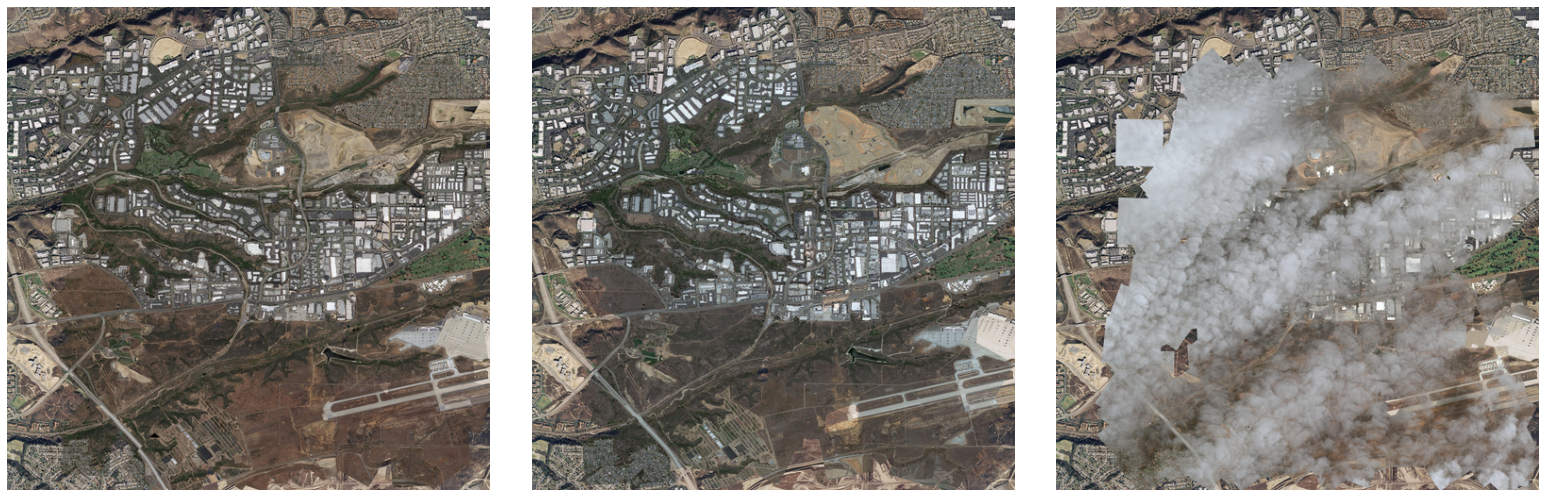

In [37]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(22, 22))
fig.tight_layout()

for i in range(3):
    img = Image.open(f'{CWD}backgrounds/background-{i}.tiff')
    img.thumbnail((512, 512), Image.ANTIALIAS)
    ax[i].imshow(img)
    ax[i].set_axis_off()

In [38]:
del img, fig, ax
gc.collect()

32173

# Генерация данных, аугментации

Так как мы создали новые подложки, то будем генерировать новые изображения из них и использовать для обучения. Генерация производится на лету, и реализована в классе ImageDataset

Также в обучении будем использовать различные аугментации:
- CoarseDropout, вырезание прямоугольных областей в изображении
- GridDropout, вырезание прямоугольных областей изображения в виде сетки
- PixelDropout, выбрасываем случайные пиксели из изображения 
- RandomBrightnessContrast - случайное изменение яркости и контрастности
- MultiplicativeNoise - умножение изображения на случайное число или массив чисел

Посмотрим как выглядят эти аугментации

In [5]:
transforms_train = transform=get_transforms(image_width=512, image_height=512, add_augmentations=True)
transforms_test = get_transforms(image_width=512, image_height=512, add_augmentations=False)

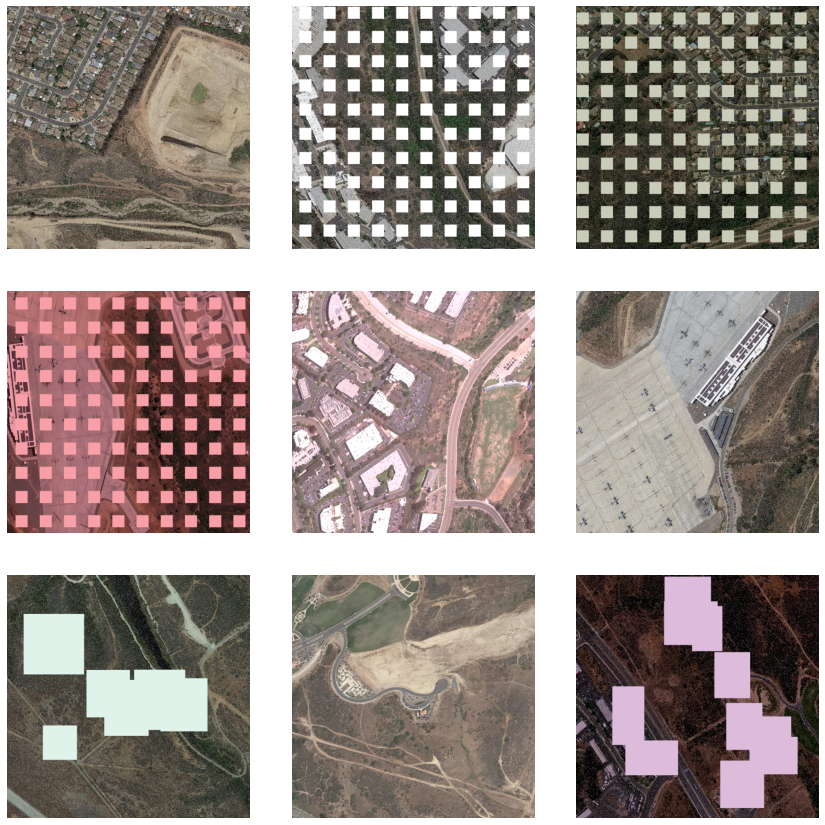

In [63]:
vis_dataset = ImageDataset(data_df.iloc[:9], background_image_paths=None, add_data = False, transform=transforms_train)

images = []
for i in range(9):
    image = vis_dataset.__getitem__(i)[0]
    image = image.squeeze(0)
    image = image.permute(1, 2, 0)
    image = image * torch.tensor([0.229, 0.224, 0.225])
    image = image + torch.tensor([0.485, 0.456, 0.406])
    images.append(image)

fig, ax = plt.subplots(nrows = 3, ncols = 3, figsize=(12, 12))
fig.tight_layout()

for i in range(3):
    for j in range(3):
        ax[i][j].imshow(images[3 * i + j])
        ax[i][j].set_axis_off()

In [64]:
del vis_dataset, image, images, fig, ax
gc.collect()

32946

# Обучение

Разобьем наши данные на обучающую и валидационную выборки

In [28]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, random_state=0)
train_df, valid_df = train_df.reset_index(), valid_df.reset_index()

Создадим ImageDataset и их загрузчики для обучающей и валидационной выборок. </br>
Будем использовать обучающую выборку и дополнительно сгенерированные данные для обучения - для этого используем представленную подложку и несколько созданных нами ранее подложек

In [33]:
train_dataset  = ImageDataset(train_df,
                              background_image_paths=[f'{CWD}original.tiff',
                                                      f'{CWD}backgrounds/background-0.tiff',
                                                      f'{CWD}backgrounds/background-1.tiff',
                                                      f'{CWD}backgrounds/background-2.tiff'],
                              add_data = True,
                              transform=transforms_train)

valid_dataset = ImageDataset(valid_df,
                             background_image_paths=None,
                             add_data = False,
                             transform=transforms_test)

In [34]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)

valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                           batch_size=1,
                                           shuffle=False,
                                           num_workers=1)

Создадим модель - будем использовать модифицированный NFNet (Normalization Free Net), использующий ECA (Efficient Channel Attention) и функцию активации SiLU

In [35]:
class Model(nn.Module):
    def __init__(self, in_channels=3, num_classes=5, pretrained=True):
        super().__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.nfnet = timm.create_model("eca_nfnet_l2", pretrained=pretrained)
        self.nfnet.head.fc = nn.Linear(self.nfnet.head.fc.in_features, self.num_classes)

    def forward(self, x):
        x = self.nfnet(x)
        return x

Обучим нашу модель и сохраним ее веса и историю обучения. Для функции потерь будем использовать модифицированную функцию, основанную на MSE. Также будем аккумулировать градиент чтобы сэмулировать больший размер батча, будем обрезать градиент по норме каждого батча.

In [43]:
!mkdir -p {CWD}weights/
weights_path = f'{CWD}weights/nfnet.pth.tar'
history_path = f'{CWD}weights/history_nfnet'

if Path(weights_path).is_file() and Path(history_path).is_file():
    print('Веса найдены - пропускаем обучение')
    with open(history_path, 'rb') as handle:
        history = dill.load(handle)
else:
    print('Начинаем обучение')
    model = Model().to(device)
    epochs = 200
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.000001, last_epoch=-1)
    history = train(model, optimizer, criterion, train_loader, valid_loader, epochs, lr_scheduler, weights_path,
                accumulate_every_n_epochs=2,
                clip_gradient=True)
    with open(history_path, 'wb') as handle:
        dill.dump(history, handle, protocol=dill.HIGHEST_PROTOCOL)

Веса найдены - пропускаем обучение


Посмотрим как проходило обучения на графиках

In [44]:
x = list(range(1, 201))
train_loss = [e.train_loss for e in history]
val_loss = [e.val_loss for e in history]
val_metric = [e.val_metric for e in history]

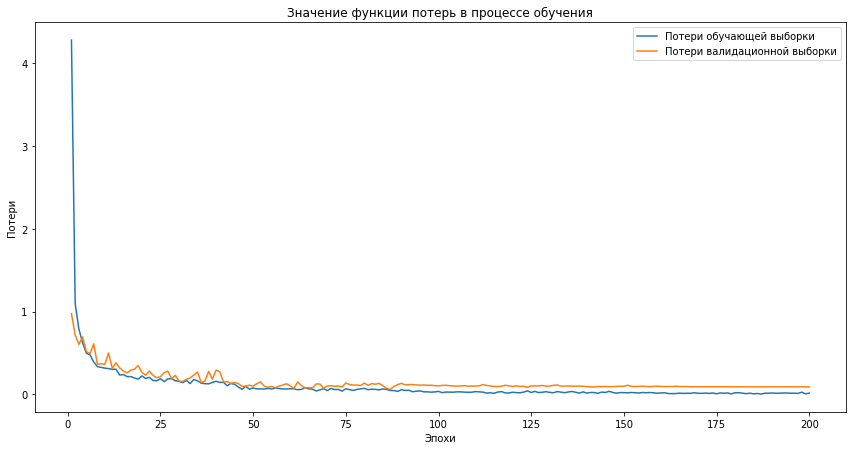

In [45]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, train_loss, label = f'Потери обучающей выборки')
ax.plot(x, val_loss, label = f'Потери валидационной выборки')
ax.set_title(f'Значение функции потерь в процессе обучения')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Потери')
ax.legend();

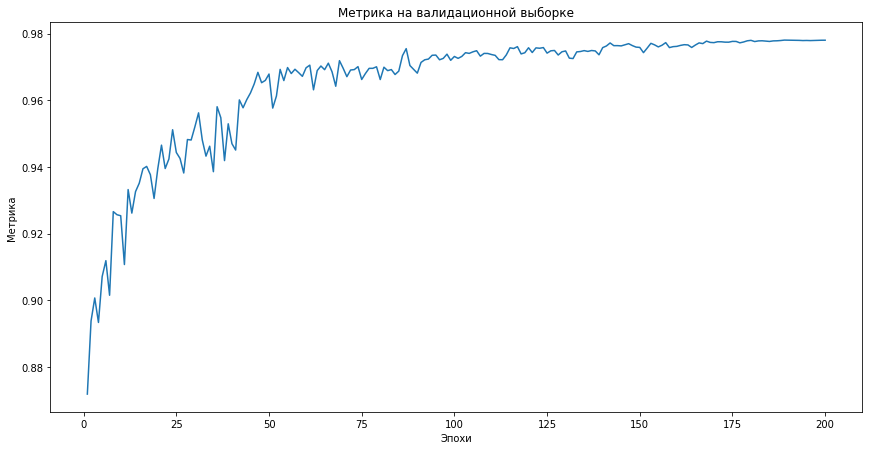

In [46]:
fig, ax = plt.subplots(figsize=(12, 6))
fig.tight_layout()

ax.plot(x, val_metric, label = f'Метрика')
ax.set_title(f'Метрика на валидационной выборке')
ax.set_xlabel('Эпохи')
ax.set_ylabel('Метрика');

# Предсказание

Создадим список файлов для предсказания и их имена

In [6]:
test_df = pd.DataFrame(get_file_paths('/content/test'), columns=['path'])
test_df['id'] = test_df['path'].apply(lambda x:x.split('/')[-1].split('.')[0])
test_df.head()

,path,id
0,/content/test/1196.png,1196
1,/content/test/1193.png,1193
2,/content/test/1192.png,1192
3,/content/test/1179.png,1179
4,/content/test/1177.png,1177


In [7]:
!mkdir -p /content/submission

Загрузим веса обученной модели

In [10]:
weights_path = f'{CWD}weights/nfnet.pth.tar'
model = torch.load(weights_path)

Предскажем и сохраним файлы json в указанную директорию

In [11]:
predict_and_save(model = model,
                 transform = transforms_test,
                 data_df = test_df,
                 path = f'{CWD}submission/',
                 device = device)

Создадим архив - решение готово!

In [12]:
!zip -FSrj submission.zip submission > /dev/null